# Picking up from part3.ipynb

I'm rerunning my regression analysis because I've found that depending on the random_state of my estimators, I'm getting *very* different results.

Approach:

NEW ANALYTICS:
* Test all models with cross validation to see which models are the most stable
* score of the **train** and test set to check for overfitting
* plot all the residuals between y_test and y_preds, not just looking at the averages in MAE and RMSE, to see if there are any interesting trends.

NEW MODELS:
* Repeat ever model with outliers removed
* Try a larger test_size (0.33)
* Emphasis on all models with bootstraping in the hopes that this may help my smaller dataset
* Special attent to the GradientBoost model as we were trained to use a different API for this algorithm. Tweak the hyperparameters carefully.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
# Import file
df_for_regression = pd.read_csv('data/data_for_regression.csv', index_col='Municipality Name')

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE

In [4]:
# Raw Data

X0 = df_for_regression.drop(columns=['%recycle/hh'])
y0 = df_for_regression['%recycle/hh']

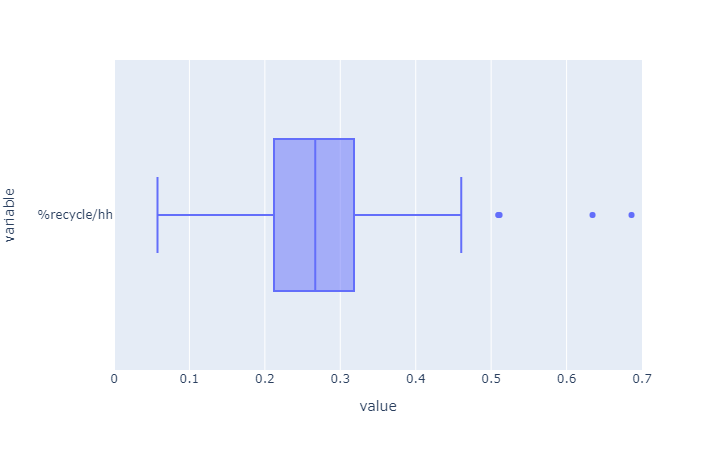

In [13]:
px.box(y0, orientation = 'h', range_x=(0,0.7))

In [8]:
# Data w/o outliers
df_for_regression1 = df_for_regression[df_for_regression['%recycle/hh'] < 0.5]
X1 = df_for_regression1.drop(columns=['%recycle/hh'])
y1 = df_for_regression1['%recycle/hh']

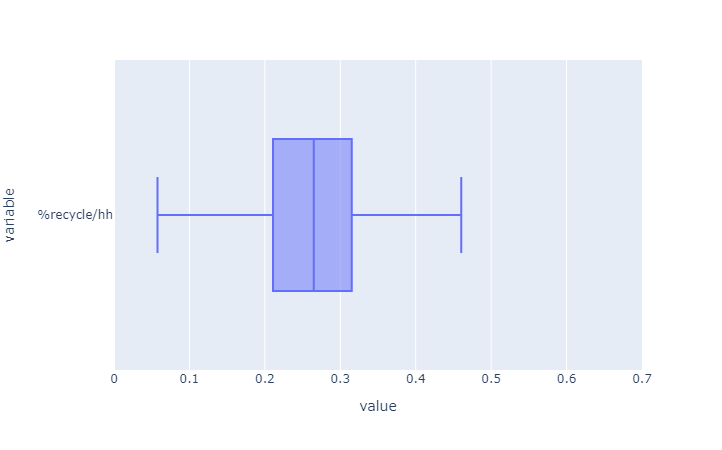

In [12]:
px.box(y1, orientation = 'h', range_x=(0,0.7))

## Cross Validation Analysis

**First** just going to look at fast models, (no grad boost) and just the raw data. I found [this nifty way of seeing the test train splits in the KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

#### Raw Data

In [6]:
cv_results = {}
cv_kf = KFold(n_splits=5, shuffle=True, random_state=8)

cv_set = 0
for train_index, test_index in cv_kf.split(X0):
    print("CV_KF set: ", cv_set)
    print("TRAIN:", train_index)
    print("TEST:", test_index)
    cv_set = cv_set + 1

CV_KF set:  0
TRAIN: [  0   1   2   5   6   7   8   9  10  11  12  14  15  16  17  18  19  20
  21  24  27  28  29  31  32  33  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  54  55  57  58  59  60  61  63  64  65  66
  67  68  69  70  72  73  74  75  76  81  83  84  85  86  88  89  90  91
  92  95  96  97  98  99 101 102 104 105 106 107 108 109 112 115 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 142 143 144 145 146 147 149 150 151 152 153 154 155 156
 157 159 160 161 162 164 166 167 168 169 170 171 172 173 174 175 176 179
 181 183 184 186 188 189 190 191 194 195 196 197 199 200 201 202 203 205
 206 207 208 210 211 213 214 215 216 217 218 220 223 224 225 226 227 228
 229 231 234 235 236 237 238 239 240 241 242 243 245 246 247 248 249 250
 251 252 253 254 255 257 258 259 261 262 263 264 265 266 267 268 269 270]
TEST: [  3   4  13  22  23  25  26  30  34  52  53  56  62  71  77  78  79  80
  82  87  93  94 100 10

In [7]:
cv = cross_val_score(DummyRegressor(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_dummy'] = np.append(cv,cv_mean)
cv

array([-0.00262471, -0.01296429, -0.03149499, -0.03040279, -0.074853  ])

In [8]:
cv = cross_val_score(LinearRegression(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_lr'] = np.append(cv,cv_mean)
cv

array([-0.08579309, -0.42197651,  0.12508735, -0.01904092, -0.46782195])

In [9]:
cv = cross_val_score(Ridge(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_ridge'] = np.append(cv,cv_mean)
cv

array([-0.02700948, -0.38914783,  0.13313634,  0.00084912, -0.44299328])

In [10]:
cv = cross_val_score(Lasso(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_lasso'] = np.append(cv,cv_mean)
cv

array([ 0.02981099,  0.02036987, -0.01632682, -0.04080895, -0.30929207])

In [11]:
cv = cross_val_score(RandomForestRegressor(random_state=8), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_RF'] = np.append(cv,cv_mean)
cv

array([ 0.03086535,  0.19833803,  0.11729076, -0.17294445,  0.21163409])

In [12]:
cv = cross_val_score(BaggingRegressor(random_state=8), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_bagging'] = np.append(cv,cv_mean)
cv

array([-0.0169631 , -0.08887127,  0.04728323, -0.211642  ,  0.03888159])

In [13]:
pd.DataFrame(cv_results, index = ['Fold1','Fold2','Fold3','Fold4','Fold5','CV_mean'])

,X0_dummy,X0_lr,X0_ridge,X0_lasso,X0_RF,X0_bagging
Fold1,-0.002625,-0.085793,-0.027009,0.029811,0.030865,-0.016963
Fold2,-0.012964,-0.421977,-0.389148,0.020370,0.198338,-0.088871
Fold3,-0.031495,0.125087,0.133136,-0.016327,0.117291,0.047283
Fold4,-0.030403,-0.019041,0.000849,-0.040809,-0.172944,-0.211642
Fold5,-0.074853,-0.467822,-0.442993,-0.309292,0.211634,0.038882
CV_mean,-0.030468,-0.173909,-0.145033,-0.063249,0.077037,-0.046262


okay, looks like Random Forest did best. However, if I used the train test split in fold 3, I could potentially get away with using linear regressions. **Next**, let's look at the same models but on the data with no outlier.

#### Data without Outliers

In [14]:
cv_set = 0
for train_index, test_index in cv_kf.split(X1):
    print("CV_KF set: ", cv_set)
    print("TRAIN:", train_index)
    print("TEST:", test_index)
    cv_set = cv_set + 1

CV_KF set:  0
TRAIN: [  0   1   2   5   6   7   8   9  10  11  12  14  15  16  17  18  19  20
  21  24  27  28  29  31  32  33  35  36  37  38  39  40  41  43  44  45
  46  47  48  49  50  51  52  53  54  57  58  59  60  61  63  64  65  66
  67  68  70  71  72  73  74  75  76  79  81  83  85  86  88  89  90  91
  93  95  97  98  99 100 101 102 104 105 106 107 108 112 113 114 115 118
 119 120 121 122 123 124 125 126 127 129 130 133 134 135 136 137 138 139
 140 141 142 143 144 146 147 148 150 151 152 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 170 171 173 174 177 178 179 180 181 182
 183 184 185 188 190 191 192 193 194 195 196 199 200 201 202 203 204 205
 206 208 209 211 212 213 214 215 216 217 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 240 241 242 243 244 245 248
 249 250 251 252 254 255 256 257 258 260 262 263 264 265 266]
TEST: [  3   4  13  22  23  25  26  30  34  42  55  56  62  69  77  78  80  82
  84  87  92  94  96 103 109 110 11

In [15]:
cv = cross_val_score(DummyRegressor(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_dummy'] = np.append(cv,cv_mean)
cv

array([-0.05338701, -0.03622173, -0.07998282, -0.00190992, -0.00161515])

In [16]:
cv = cross_val_score(LinearRegression(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_lr'] = np.append(cv,cv_mean)
cv

array([ 0.11681536, -0.02302504, -0.60246096,  0.14584508,  0.16238194])

In [17]:
cv = cross_val_score(Ridge(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_ridge'] = np.append(cv,cv_mean)
cv

array([ 0.2425074 ,  0.00398809, -0.63989767,  0.19700119,  0.18435423])

In [18]:
cv = cross_val_score(Lasso(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_lasso'] = np.append(cv,cv_mean)
cv

array([-0.03725743, -0.00609516, -0.42253981,  0.02625488,  0.00080746])

In [19]:
cv = cross_val_score(RandomForestRegressor(random_state=8), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_RF'] = np.append(cv,cv_mean)
cv

array([0.2165107 , 0.14495103, 0.09073038, 0.30272136, 0.23477095])

In [20]:
cv = cross_val_score(BaggingRegressor(random_state=8), X1, y1, cv=cv_kf)
cv_mean = cv.mean()
cv_results['X1_bagging'] = np.append(cv,cv_mean)
cv

array([0.32835449, 0.08558503, 0.06803691, 0.34382283, 0.18444288])

In [21]:
pd.DataFrame(cv_results, index = ['Fold1','Fold2','Fold3','Fold4','Fold5','CV_mean'])

,X0_dummy,X0_lr,X0_ridge,X0_lasso,X0_RF,X0_bagging,X1_dummy,X1_lr,X1_ridge,X1_lasso,X1_RF,X1_bagging
Fold1,-0.002625,-0.085793,-0.027009,0.029811,0.030865,-0.016963,-0.053387,0.116815,0.242507,-0.037257,0.216511,0.328354
Fold2,-0.012964,-0.421977,-0.389148,0.020370,0.198338,-0.088871,-0.036222,-0.023025,0.003988,-0.006095,0.144951,0.085585
Fold3,-0.031495,0.125087,0.133136,-0.016327,0.117291,0.047283,-0.079983,-0.602461,-0.639898,-0.422540,0.090730,0.068037
Fold4,-0.030403,-0.019041,0.000849,-0.040809,-0.172944,-0.211642,-0.001910,0.145845,0.197001,0.026255,0.302721,0.343823
Fold5,-0.074853,-0.467822,-0.442993,-0.309292,0.211634,0.038882,-0.001615,0.162382,0.184354,0.000807,0.234771,0.184443
CV_mean,-0.030468,-0.173909,-0.145033,-0.063249,0.077037,-0.046262,-0.034623,-0.040089,-0.002409,-0.087766,0.197937,0.202048


Okay, everything does seem to improve when removing the outliers. Looks like the non-linear regression based models still faired best but the set from fold 4 performed well across all models. The outliers, however, are in the positive direction: higher recyclers. So if I do go with a model with the outliers removed, I still need to go back and see what is unique about those outliers; I shouldn't just throw them out and forget about them.

### Cross Validation with Larger Test:Train Ratio

I can kinda of informally see how the dataset does with a higher test ratio by changing the n_split during the cross validation. Above, I used the default of 5, however, this only leaves us with 54 test points. We may increase our odds of success by increasing this quantity so I'll change the n_split to 3.

In [22]:
cv_results = {}
cv_kf = KFold(n_splits=3, shuffle=True, random_state=8)

cv_set = 0
for train_index, test_index in cv_kf.split(X0):
    print("CV_KF set: ", cv_set)
    print("TRAIN:", train_index)
    print("TEST:", test_index)
    cv_set = cv_set + 1

CV_KF set:  0
TRAIN: [  2   6   7   8   9  10  11  12  14  15  16  18  19  20  21  24  27  28
  29  31  32  35  36  37  38  40  41  43  44  46  47  48  49  50  51  54
  58  59  60  61  63  64  66  67  68  70  73  74  75  76  81  83  85  86
  89  90  91  92  95  97  98  99 101 102 104 105 106 107 108 112 115 117
 118 119 120 121 122 123 124 125 126 127 128 130 131 132 133 134 135 136
 137 138 140 141 142 143 144 145 147 150 152 153 154 155 156 159 160 161
 162 164 166 167 168 169 170 171 173 174 175 176 179 181 183 184 188 190
 191 194 195 196 199 200 201 203 205 206 207 210 211 213 214 216 217 220
 223 224 225 226 228 229 231 234 235 236 237 238 239 242 243 245 246 247
 248 249 250 251 252 253 254 255 257 258 259 261 262 264 266 267 269 270]
TEST: [  0   1   3   4   5  13  17  22  23  25  26  30  33  34  39  42  45  52
  53  55  56  57  62  65  69  71  72  77  78  79  80  82  84  87  88  93
  94  96 100 103 109 110 111 113 114 116 129 139 146 148 149 151 157 158
 163 165 172 177 178 18

In [23]:
cv = cross_val_score(DummyRegressor(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_dummy'] = np.append(cv,cv_mean)
cv

array([-0.01458113, -0.01553683, -0.09007735])

In [24]:
cv = cross_val_score(LinearRegression(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_lr'] = np.append(cv,cv_mean)
cv

array([-0.08721139,  0.15905641, -0.75862946])

In [25]:
cv = cross_val_score(Ridge(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_ridge'] = np.append(cv,cv_mean)
cv

array([-0.01603247,  0.16700945, -0.74216146])

In [26]:
cv = cross_val_score(Lasso(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_lasso'] = np.append(cv,cv_mean)
cv

array([ 0.01745458,  0.00209897, -0.74093297])

In [27]:
cv = cross_val_score(RandomForestRegressor(random_state=8), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_RF'] = np.append(cv,cv_mean)
cv

array([0.11768537, 0.2370164 , 0.11437933])

In [28]:
cv = cross_val_score(BaggingRegressor(random_state=8), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_bagging'] = np.append(cv,cv_mean)
cv

array([-0.04694505,  0.11108638,  0.03541457])

In [29]:
cv_set = 0
for train_index, test_index in cv_kf.split(X1):
    print("CV_KF set: ", cv_set)
    print("TRAIN:", train_index)
    print("TEST:", test_index)
    cv_set = cv_set + 1

CV_KF set:  0
TRAIN: [  2   6   7   8   9  10  11  12  14  15  16  18  19  20  21  24  27  28
  29  31  32  35  36  37  38  40  41  43  44  46  47  48  49  50  51  52
  53  54  58  59  60  61  63  64  66  67  68  70  71  73  74  75  76  81
  83  85  86  89  90  91  93  95  97  98  99 101 102 104 105 106 107 108
 112 114 115 118 119 120 122 123 124 125 126 127 129 130 133 134 135 136
 137 138 140 142 143 144 147 148 150 152 154 155 156 158 159 160 162 163
 165 166 167 168 170 173 174 177 178 179 180 181 182 183 184 185 188 190
 191 192 194 195 196 199 200 202 203 205 208 209 211 213 215 216 217 219
 220 221 223 225 227 228 229 230 231 232 233 234 235 236 237 240 241 243
 244 245 249 250 251 252 254 255 257 258 260 262 263 264 265 266]
TEST: [  0   1   3   4   5  13  17  22  23  25  26  30  33  34  39  42  45  55
  56  57  62  65  69  72  77  78  79  80  82  84  87  88  92  94  96 100
 103 109 110 111 113 116 117 121 128 131 132 139 141 145 146 149 151 153
 157 161 164 169 171 172 175 17

In [30]:
cv = cross_val_score(DummyRegressor(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_dummy'] = np.append(cv,cv_mean)
cv

array([-0.08957878, -0.1209515 , -0.01201351])

In [31]:
cv = cross_val_score(LinearRegression(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_lr'] = np.append(cv,cv_mean)
cv

array([ 0.01517724, -0.38834619,  0.10209835])

In [32]:
cv = cross_val_score(Ridge(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_ridge'] = np.append(cv,cv_mean)
cv

array([ 0.08972173, -0.38117819,  0.16464953])

In [33]:
cv = cross_val_score(Lasso(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_lasso'] = np.append(cv,cv_mean)
cv

array([-0.06988468, -0.23457381,  0.00298756])

In [34]:
cv = cross_val_score(RandomForestRegressor(random_state=8), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_RF'] = np.append(cv,cv_mean)
cv

array([0.19785585, 0.00528953, 0.20736793])

In [35]:
cv = cross_val_score(BaggingRegressor(random_state=8), X1, y1, cv=cv_kf)
cv_mean = cv.mean()
cv_results['X1_bagging'] = np.append(cv,cv_mean)
cv

array([ 0.16058833, -0.06794259,  0.13272154])

In [36]:
pd.DataFrame(cv_results, index = ['Fold1','Fold2','Fold3', 'CV_mean'])

,X0_dummy,X0_lr,X0_ridge,X0_lasso,X0_RF,X0_bagging,X1_dummy,X1_lr,X1_ridge,X1_lasso,X1_RF,X1_bagging
Fold1,-0.014581,-0.087211,-0.016032,0.017455,0.117685,-0.046945,-0.089579,0.015177,0.089722,-0.069885,0.197856,0.160588
Fold2,-0.015537,0.159056,0.167009,0.002099,0.237016,0.111086,-0.120952,-0.388346,-0.381178,-0.234574,0.005290,-0.067943
Fold3,-0.090077,-0.758629,-0.742161,-0.740933,0.114379,0.035415,-0.012014,0.102098,0.164650,0.002988,0.207368,0.132722
CV_mean,-0.040065,-0.228928,-0.197061,-0.240460,0.156360,0.033185,-0.074181,-0.090357,-0.042269,-0.100490,0.136838,0.075122


So, the averages definitely seem better. It does mean I've only tested 3 configurations rather than 5 but RF consistently is positive and bagging does fairly well. It also seems like the difference between the data with the outliers and without the outliers in this CV analysis has fewer differences in fit. It seems like increasing the test_split will be helpful.

---

### Take Aways

There probably is no linear relationship between my dependent variable and the rest of the dataset; this means that tree-based regressors will fair much better *consistently*. This intuitively makes sense to me because I have so many binary features that this inheriently lends itself better to decision trees, not so much for linear regression. This also gives me more hope that a neural network may fair well (more on that later).

I think moving forward, I'm going to do the normal train_test_split method, excluding the outliers for now, and with a regular test_train split for the baseline, but a test_size = 0.33 for the clusters. I will only look at models based on decision trees. I am especially interested in models that support bootstrapping since my dataset isn't huge. So the models I'll look at are: RandomForests (bootstrapping), Bagging (bootstrapping), and Gradient Boosting (adding this one in). [Source to look at other tree-based ensembles](https://scikit-learn.org/stable/modules/classes.html?highlight=ensemble#module-sklearn.ensemble)

#### slight side-track showing how the data is not linearly seperable overlaid on PCA data

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [28]:
pca = PCA(n_components=3, random_state=8)
ss = StandardScaler()

In [29]:
X_s = ss.fit_transform(X1)
X_pca= pca.fit_transform(X_s)

In [30]:
pca.explained_variance_ratio_

array([0.1579751 , 0.08377354, 0.0650413 ])

In [35]:
X_pca = pd.DataFrame(X_pca, columns=['z1', 'z2', 'z3'])

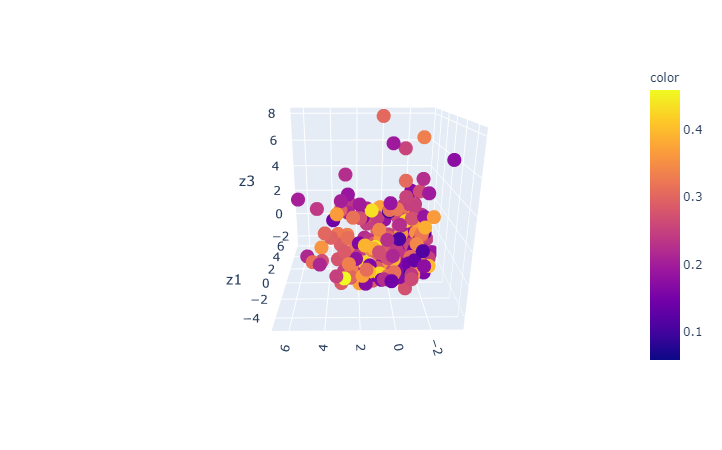

In [37]:
px.scatter_3d(X_pca, x='z1', y = 'z2', z='z3', color=y1)

clearly no visible pattern.

---

## Regression

After each fit, I'll show the residuals between the ground-truth y and the y predicted, just to see if there is any information to be gleaned. 

In [15]:
# data w/o outliers

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size= 0.2, random_state=8)

In [38]:
fit_results = {}

def fit_model(model, name):
    model.fit(X_train, y_train)
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)
    mae = mean_absolute_error(y_test, model.predict(X_test))
    fit_results[name] = (score_train, score_test, rmse, mae)
    return score_test

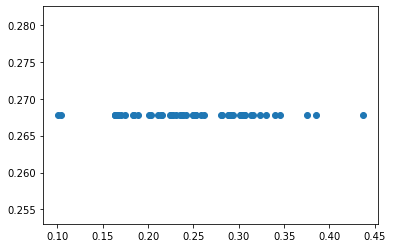

In [39]:
model0 = DummyRegressor()
fit_model(model0, 'dummy')
plt.scatter(y_test, model0.predict(X_test));

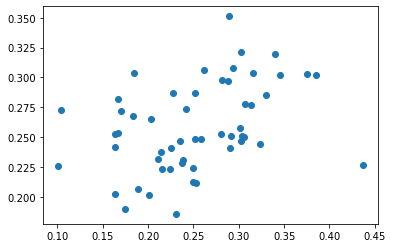

In [40]:
model1 = RandomForestRegressor(n_jobs=-1, random_state=8)
fit_model(model1, 'RFR')
plt.scatter(y_test, model1.predict(X_test));

In [41]:
rf_coefs = np.mean([
    tree.feature_importances_ for tree in model1.estimators_
], axis=0)
rf_coefs

array([1.02459199e-02, 4.30696139e-03, 4.14090300e-02, 5.75614300e-02,
       2.39772288e-02, 2.17783979e-01, 5.65786971e-03, 1.09164389e-03,
       1.88582228e-04, 1.04702554e-02, 5.37874662e-03, 6.24755501e-03,
       1.53860525e-02, 1.03097593e-02, 4.45659488e-03, 5.72659525e-04,
       8.61560081e-03, 5.03281409e-03, 7.55466580e-03, 2.07173074e-02,
       1.25303982e-02, 1.09759110e-02, 1.61912546e-01, 2.30147815e-02,
       5.64631459e-03, 1.79663809e-03, 3.89648265e-04, 1.60112125e-01,
       6.61438554e-03, 5.26835008e-03, 1.51455027e-02, 9.44857176e-03,
       1.78943722e-02, 8.41618365e-03, 6.22577759e-03, 8.88845283e-03,
       1.44253585e-02, 2.54642168e-03, 5.63188661e-03, 1.51732940e-02,
       7.69529001e-03, 2.22382068e-02, 2.10449269e-02])

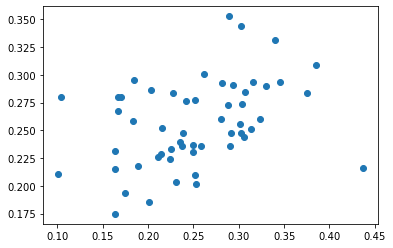

In [42]:
model2 = BaggingRegressor(n_jobs=-1, random_state=8)
fit_model(model2, 'bagging')
plt.scatter(y_test, model2.predict(X_test));

In [43]:
bagging_trees_coefs = {}
for tree in range(len(model2.estimators_)):
    bagging_trees_coefs[tree] = dict(zip(model2.estimators_features_[tree], model2.estimators_[tree].feature_importances_))

bagging_trees_coefs = pd.DataFrame(bagging_trees_coefs).sort_index()
bagging_coefs = bagging_trees_coefs.mean(axis=1)
bagging_coefs

0     0.009805
1     0.001894
2     0.039647
3     0.075626
4     0.029937
5     0.218387
6     0.001582
7     0.002870
8     0.000090
9     0.010576
10    0.007001
11    0.007004
12    0.022411
13    0.003542
14    0.000022
15    0.000043
16    0.009378
17    0.003616
18    0.007408
19    0.027106
20    0.011283
21    0.005406
22    0.146852
23    0.029420
24    0.005408
25    0.004768
26    0.000533
27    0.163144
28    0.013872
29    0.007179
30    0.015681
31    0.004786
32    0.012087
33    0.008812
34    0.005160
35    0.010613
36    0.009774
37    0.000969
38    0.005953
39    0.017672
40    0.007972
41    0.016494
42    0.018217
dtype: float64

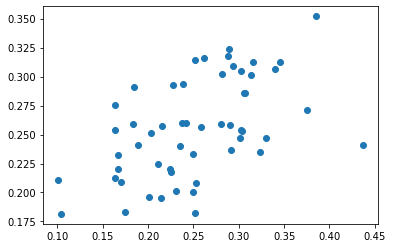

In [47]:
model3 = GradientBoostingRegressor(min_samples_leaf=5, random_state=8)
fit_model(model3, 'GradBoost')
plt.scatter(y_test, model3.predict(X_test));

In [48]:
gradboost_coefs = np.mean([
    tree.feature_importances_ for tree in model1.estimators_
], axis=0)

In [49]:
pd.DataFrame(fit_results,index=['score_train', 'score_test', 'rmse', 'mae'])

,dummy,RFR,bagging,GradBoost
score_train,0.000000,0.877199,0.818654,0.762934
score_test,-0.053387,0.112167,0.103615,0.264901
rmse,0.069744,0.064029,0.064337,0.058262
mae,0.056825,0.048348,0.048128,0.045675


Looks like in each model we have a very decent train fit but the test fit is not great.

## Random Forest

[Hyperparameters](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor) of interest:

* **n_estimators**-- how many trees in forest. Seems simple enough to test a few.
* **max_samples** -- By default, it's all of the X's in the training set. However, I'm curious to see how decreasing this quantity may impact the residuals of y_preds vs y_test.
* **criterion** {“mse”, “mae”}, default=”mse” -- according to the docs, "The function to measure the quality of a split. Supported criteria are “mse” for the mean squared error, which is equal to variance reduction as feature selection criterion, and “mae” for the mean absolute error." I think this may be suggesting that if I have issues with model-variance (overfitting), I may want to change the criterion to MAE.
* **max_features** -- this could be an interesting pseudo RFE
* **min_impurity_decrease** -- this may be better than looking at max leave nodes if I care more about how much the model is improve, rather than complexity (which may be driving up model complexity). Otherwise, I may want to look at **max_depth**
* **ccp_alpha** -- This parameter is used to effectively prune out any highly complex models. I don't really know how to use this but I may study this more if model-variance still seems to be an issue.

In [50]:
params_rf = {
    'n_estimators': [10,100,1000],
    'max_samples': [None, 0.66, 0.33],
    'min_impurity_decrease': [0.0, 0.05, 0.1]
}

In [51]:
kf = KFold(n_splits=5, shuffle = True, random_state= 8)

In [79]:
model1a = RandomForestRegressor(criterion='mse', random_state=8)

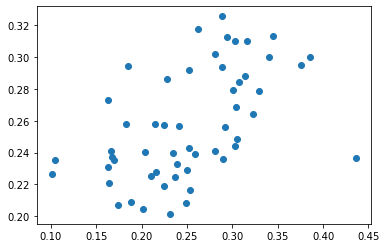

In [80]:
gs1a = GridSearchCV(estimator=model1a, param_grid=params_rf, cv=kf, n_jobs=-1)
fit_model(gs1a, 'GS_RF_MSE')
plt.scatter(y_test, gs1a.predict(X_test));

In [81]:
pd.DataFrame(gs1a.cv_results_).sort_values('mean_test_score', ascending=False).iloc[:5,4:]

,param_max_samples,param_min_impurity_decrease,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,0.33,0,1000,"{'max_samples': 0.33, 'min_impurity_decrease':...",0.212362,0.138097,0.136102,0.267847,-0.007611,0.149359,0.092683,1
19,0.33,0,100,"{'max_samples': 0.33, 'min_impurity_decrease':...",0.182018,0.116053,0.147932,0.295356,-0.000747,0.148122,0.095935,2
11,0.66,0,1000,"{'max_samples': 0.66, 'min_impurity_decrease':...",0.099296,0.158949,0.137450,0.264871,-0.080619,0.115989,0.112610,3
10,0.66,0,100,"{'max_samples': 0.66, 'min_impurity_decrease':...",0.090492,0.110327,0.127613,0.258644,-0.041308,0.109154,0.095579,4
2,None,0,1000,"{'max_samples': None, 'min_impurity_decrease':...",0.036060,0.161972,0.120936,0.242111,-0.151386,0.081939,0.134258,5


In [82]:
pd.DataFrame(fit_results,index=['score_train', 'score_test', 'rmse', 'mae'])

,dummy,RFR,bagging,GradBoost,GS_RF_MSE,GS_RF_MAE,GS_RF_MAE2,rfr_op
score_train,0.000000,0.877199,0.818654,0.762934,0.574628,0.575958,0.565554,0.574628
score_test,-0.053387,0.112167,0.103615,0.264901,0.259833,0.241781,0.256861,0.259833
rmse,0.069744,0.064029,0.064337,0.058262,0.058462,0.059171,0.058579,0.058462
mae,0.056825,0.048348,0.048128,0.045675,0.044952,0.045210,0.045153,0.044952


In [75]:
model1b = RandomForestRegressor(criterion='mae', random_state=8)

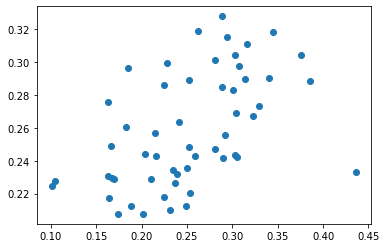

In [76]:
gs1b = GridSearchCV(estimator=model1b, param_grid=params_rf, cv=kf, n_jobs=-1)
fit_model(gs1b, 'GS_RF_MAE')
plt.scatter(y_test, gs1b.predict(X_test));

In [77]:
pd.DataFrame(gs1b.cv_results_).sort_values('mean_test_score', ascending=False).iloc[:5,4:]

,param_max_samples,param_min_impurity_decrease,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,0.33,0,100,"{'max_samples': 0.33, 'min_impurity_decrease':...",0.201949,0.130122,0.119941,0.282433,0.035509,0.153991,0.083144,1
20,0.33,0,1000,"{'max_samples': 0.33, 'min_impurity_decrease':...",0.195951,0.134080,0.138191,0.273402,0.019690,0.152263,0.083292,2
11,0.66,0,1000,"{'max_samples': 0.66, 'min_impurity_decrease':...",0.113241,0.159844,0.141043,0.275288,-0.063674,0.125148,0.109356,3
10,0.66,0,100,"{'max_samples': 0.66, 'min_impurity_decrease':...",0.108142,0.114716,0.166550,0.260632,-0.045479,0.120912,0.099491,4
2,None,0,1000,"{'max_samples': None, 'min_impurity_decrease':...",0.070953,0.173463,0.141232,0.275110,-0.122791,0.107593,0.132629,5


In [83]:
pd.DataFrame(fit_results,index=['score_train', 'score_test', 'rmse', 'mae'])

,dummy,RFR,bagging,GradBoost,GS_RF_MSE,GS_RF_MAE,GS_RF_MAE2,rfr_op
score_train,0.000000,0.877199,0.818654,0.762934,0.574628,0.575958,0.565554,0.574628
score_test,-0.053387,0.112167,0.103615,0.264901,0.259833,0.241781,0.256861,0.259833
rmse,0.069744,0.064029,0.064337,0.058262,0.058462,0.059171,0.058579,0.058462
mae,0.056825,0.048348,0.048128,0.045675,0.044952,0.045210,0.045153,0.044952


Looks like MSE and MAE is fairly close. Probably means that the MSE isn't being impacted as heavily by the outliers as I feared. So I think I can keep going with MSE as my criteron. Interestingly, in both cases, using a max_samples of 0.33 worked best. I'm thinking this may help with overfitting. Also, more estimators seem to help, not fewer. Playing with the impurity decrease did not help at all. I may do one more grid search looking at some more estimators and switch to max_depth instead of min_impurity_decrease.

In [65]:
params_rf2 = {
    'n_estimators': [100,1000],
    'max_samples': [0.33, 0.66, 1],
    'max_depth': [5, 10, 20, 50]
}

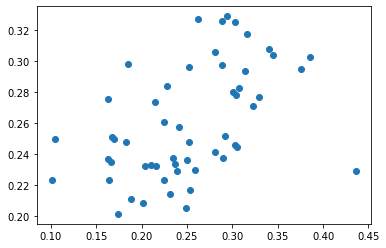

In [84]:
gs1c = GridSearchCV(estimator=model1a, param_grid=params_rf2, cv=kf, n_jobs=-1)
fit_model(gs1c, 'GS_RF_MSE2')
plt.scatter(y_test, gs1c.predict(X_test));

In [85]:
pd.DataFrame(gs1c.cv_results_).sort_values('mean_test_score', ascending=False).iloc[:5,4:]

,param_max_depth,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5,0.33,100,"{'max_depth': 5, 'max_samples': 0.33, 'n_estim...",0.224798,0.098233,0.118248,0.292398,0.020247,0.150785,0.096325,1
1,5,0.33,1000,"{'max_depth': 5, 'max_samples': 0.33, 'n_estim...",0.215439,0.131678,0.131370,0.256800,0.013519,0.149761,0.083664,2
7,10,0.33,1000,"{'max_depth': 10, 'max_samples': 0.33, 'n_esti...",0.212414,0.137863,0.136125,0.265226,-0.002995,0.149727,0.090465,3
19,50,0.33,1000,"{'max_depth': 50, 'max_samples': 0.33, 'n_esti...",0.212362,0.138097,0.136102,0.267847,-0.007611,0.149359,0.092683,4
13,20,0.33,1000,"{'max_depth': 20, 'max_samples': 0.33, 'n_esti...",0.212362,0.138097,0.136102,0.267847,-0.007611,0.149359,0.092683,4


In [86]:
pd.DataFrame(fit_results,index=['score_train', 'score_test', 'rmse', 'mae'])

,dummy,RFR,bagging,GradBoost,GS_RF_MSE,GS_RF_MAE,GS_RF_MAE2,rfr_op,GS_RF_MSE2
score_train,0.000000,0.877199,0.818654,0.762934,0.574628,0.575958,0.565554,0.574628,0.501652
score_test,-0.053387,0.112167,0.103615,0.264901,0.259833,0.241781,0.256861,0.259833,0.206245
rmse,0.069744,0.064029,0.064337,0.058262,0.058462,0.059171,0.058579,0.058462,0.060542
mae,0.056825,0.048348,0.048128,0.045675,0.044952,0.045210,0.045153,0.044952,0.046327


Hm, so n_estimator truly seems best at 1000, however max_sample did even better at 0.15 which just seem crazy low. Max_depth did best at 10. However, I will say, most of these scores are really close to each other, unlike the previous gridsearch, so I think I'm reaching a capping point. I'm going to run a randomforest with my optimized parameters to see how it does on the full dataset.

In [88]:
model1c = RandomForestRegressor(n_estimators= 1000, max_samples=0.33, random_state=8)
fit_model(model1c, 'rfr_op')

0.25983327776226517

In [89]:
rf_op_coefs = np.mean([
    tree.feature_importances_ for tree in model1c.estimators_
], axis=0)

In [90]:
pd.DataFrame(fit_results,index=['score_train', 'score_test', 'rmse', 'mae'])

,dummy,RFR,bagging,GradBoost,GS_RF_MSE,GS_RF_MAE,GS_RF_MAE2,rfr_op,GS_RF_MSE2
score_train,0.000000,0.877199,0.818654,0.762934,0.574628,0.575958,0.565554,0.574628,0.501652
score_test,-0.053387,0.112167,0.103615,0.264901,0.259833,0.241781,0.256861,0.259833,0.206245
rmse,0.069744,0.064029,0.064337,0.058262,0.058462,0.059171,0.058579,0.058462,0.060542
mae,0.056825,0.048348,0.048128,0.045675,0.044952,0.045210,0.045153,0.044952,0.046327


## Bagging

[Hyperparameters of interest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor):
* **n_estimators** -- how many weak estimators
* **max_samples** -- max samples drawn
* **max_features** -- how many samples to look at
* **bootstrap_features** -- this one is new, I can bootstrap the features, not just the datapoints


In [91]:
params_bagging = {
    'n_estimators': [100,1000],
    'max_samples': [1.0, 0.66, 0.33],
    'max_features': [1.0, 0.75, 0.5]
}

In [92]:
kf = KFold(n_splits=3, shuffle = True, random_state= 8)

In [94]:
model2 = BaggingRegressor(random_state=8)

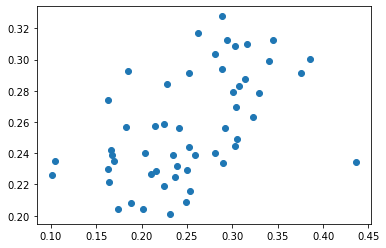

In [95]:
gs2 = GridSearchCV(estimator=model2, param_grid=params_bagging, cv=kf, n_jobs=-1)
fit_model(gs2, 'GS_bagging')
plt.scatter(y_test, gs2.predict(X_test));

In [97]:
pd.DataFrame(gs2.cv_results_).sort_values('mean_test_score', ascending=False).iloc[:5,4:]

,param_max_features,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,1,0.33,1000,"{'max_features': 1.0, 'max_samples': 0.33, 'n_...",0.154305,0.254515,0.073314,0.160711,0.074114,1
11,0.75,0.33,1000,"{'max_features': 0.75, 'max_samples': 0.33, 'n...",0.157814,0.233348,0.080070,0.157078,0.062578,2
10,0.75,0.33,100,"{'max_features': 0.75, 'max_samples': 0.33, 'n...",0.115833,0.248914,0.056507,0.140418,0.080451,3
17,0.5,0.33,1000,"{'max_features': 0.5, 'max_samples': 0.33, 'n_...",0.128187,0.201927,0.076832,0.135649,0.051341,4
4,1,0.33,100,"{'max_features': 1.0, 'max_samples': 0.33, 'n_...",0.105414,0.221399,0.040386,0.122400,0.074868,5


In [98]:
pd.DataFrame(fit_results,index=['score_train', 'score_test', 'rmse', 'mae'])

,dummy,RFR,bagging,GradBoost,GS_RF_MSE,GS_RF_MAE,GS_RF_MAE2,rfr_op,GS_RF_MSE2,GS_bagging
score_train,0.000000,0.877199,0.818654,0.762934,0.574628,0.575958,0.565554,0.574628,0.501652,0.572994
score_test,-0.053387,0.112167,0.103615,0.264901,0.259833,0.241781,0.256861,0.259833,0.206245,0.253086
rmse,0.069744,0.064029,0.064337,0.058262,0.058462,0.059171,0.058579,0.058462,0.060542,0.058728
mae,0.056825,0.048348,0.048128,0.045675,0.044952,0.045210,0.045153,0.044952,0.046327,0.045122


In [101]:
model2 = BaggingRegressor(n_estimators= 1000, max_samples = 0.33, random_state=8)
fit_model(model2, 'bagging_op')

0.25308629360067914

In [102]:
bagging_trees_coefs = {}
for tree in range(len(model2.estimators_)):
    bagging_trees_coefs[tree] = dict(zip(model2.estimators_features_[tree], model2.estimators_[tree].feature_importances_))

bagging_trees_coefs = pd.DataFrame(bagging_trees_coefs).sort_index()
bagging_op_coefs = bagging_trees_coefs.mean(axis=1)
bagging_op_coefs

0     0.011289
1     0.007331
2     0.042448
3     0.053554
4     0.016048
5     0.211106
6     0.003369
7     0.002701
8     0.000270
9     0.013367
10    0.005380
11    0.006666
12    0.014430
13    0.014682
14    0.008769
15    0.000471
16    0.010655
17    0.008089
18    0.007304
19    0.016477
20    0.013450
21    0.013700
22    0.152737
23    0.020822
24    0.004946
25    0.002188
26    0.000846
27    0.158120
28    0.008129
29    0.005571
30    0.015807
31    0.007451
32    0.017657
33    0.010483
34    0.007789
35    0.012344
36    0.013009
37    0.003783
38    0.006697
39    0.015672
40    0.012126
41    0.022587
42    0.019680
dtype: float64

In [103]:
len(model2.estimators_)

1000

In [104]:
model2.estimators_[0].feature_importances_

array([0.00000000e+00, 6.13410740e-03, 4.70170775e-02, 6.85816313e-04,
       2.30852097e-05, 1.56343241e-01, 0.00000000e+00, 8.27641155e-04,
       0.00000000e+00, 5.21769842e-02, 0.00000000e+00, 2.16452692e-06,
       7.93908834e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.97010672e-03, 0.00000000e+00, 2.42141743e-02,
       3.00951535e-05, 0.00000000e+00, 2.52079699e-01, 0.00000000e+00,
       0.00000000e+00, 1.37657451e-03, 0.00000000e+00, 1.53597978e-01,
       0.00000000e+00, 7.25387908e-03, 0.00000000e+00, 0.00000000e+00,
       4.45202345e-03, 1.69123674e-05, 1.38140047e-02, 1.89291252e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.21807034e-03,
       0.00000000e+00, 7.83820226e-02, 3.29918219e-03])

In [105]:
pd.DataFrame(fit_results,index=['score_train', 'score_test', 'rmse', 'mae'])

,dummy,RFR,bagging,GradBoost,GS_RF_MSE,GS_RF_MAE,GS_RF_MAE2,rfr_op,GS_RF_MSE2,GS_bagging,bagging_op
score_train,0.000000,0.877199,0.818654,0.762934,0.574628,0.575958,0.565554,0.574628,0.501652,0.572994,0.572994
score_test,-0.053387,0.112167,0.103615,0.264901,0.259833,0.241781,0.256861,0.259833,0.206245,0.253086,0.253086
rmse,0.069744,0.064029,0.064337,0.058262,0.058462,0.059171,0.058579,0.058462,0.060542,0.058728,0.058728
mae,0.056825,0.048348,0.048128,0.045675,0.044952,0.045210,0.045153,0.044952,0.046327,0.045122,0.045122


## Boosting

[Hyperparameters of interest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor):
* **learning_rate**, default=0.1 -- According to the docs, "Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators."
* **n_estimators** -- how many weak estimators
* **subsample** -- subs samples to be drawn for fitting (sort of like max_samples)
* **max_depth** -- default is three but this is a recommended feature to play with
* **min_impurity_decrease** --

things to try outside of gs
* **n_iter_no_change**
* **validation_fraction**
* **tol**


In [106]:
params_boosting = {
     'n_estimators': [100, 1000],
     'subsample': [1.0, 0.66, 0.33],
     'max_depth': [3, 5],
     'min_samples_leaf': [1,5,10]
}

In [107]:
kf = KFold(n_splits=3, shuffle = True, random_state= 8)

In [108]:
model3 = GradientBoostingRegressor(loss='lad', random_state=8)

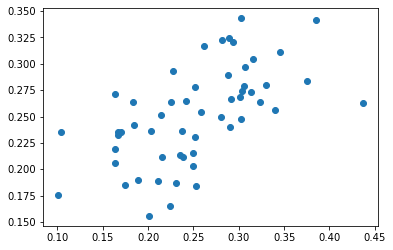

In [109]:
gs3 = GridSearchCV(estimator=model3, param_grid=params_boosting, cv=kf, n_jobs=-1)
fit_model(gs3, 'GS_boosting')
plt.scatter(y_test, gs3.predict(X_test));

In [110]:
pd.DataFrame(gs3.cv_results_).sort_values('mean_test_score', ascending=False).iloc[:5,4:]

,param_max_depth,param_min_samples_leaf,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
14,3,10,100,0.33,"{'max_depth': 3, 'min_samples_leaf': 10, 'n_es...",0.156001,0.276976,0.025887,0.152955,0.102529,1
32,5,10,100,0.33,"{'max_depth': 5, 'min_samples_leaf': 10, 'n_es...",0.156001,0.276976,0.025887,0.152955,0.102529,1
31,5,10,100,0.66,"{'max_depth': 5, 'min_samples_leaf': 10, 'n_es...",0.127186,0.199549,0.022330,0.116355,0.072754,3
12,3,10,100,1,"{'max_depth': 3, 'min_samples_leaf': 10, 'n_es...",0.114857,0.203676,0.024401,0.114312,0.073190,4
8,3,5,100,0.33,"{'max_depth': 3, 'min_samples_leaf': 5, 'n_est...",0.103095,0.217324,0.011161,0.110527,0.084330,5


In [111]:
pd.DataFrame(fit_results,index=['score_train', 'score_test', 'rmse', 'mae'])

,dummy,RFR,bagging,GradBoost,GS_RF_MSE,GS_RF_MAE,GS_RF_MAE2,rfr_op,GS_RF_MSE2,GS_bagging,bagging_op,GS_boosting
score_train,0.000000,0.877199,0.818654,0.762934,0.574628,0.575958,0.565554,0.574628,0.501652,0.572994,0.572994,0.456235
score_test,-0.053387,0.112167,0.103615,0.264901,0.259833,0.241781,0.256861,0.259833,0.206245,0.253086,0.253086,0.340277
rmse,0.069744,0.064029,0.064337,0.058262,0.058462,0.059171,0.058579,0.058462,0.060542,0.058728,0.058728,0.055194
mae,0.056825,0.048348,0.048128,0.045675,0.044952,0.045210,0.045153,0.044952,0.046327,0.045122,0.045122,0.045027


In [115]:
model3 = GradientBoostingRegressor(loss='lad', max_depth=3, min_samples_leaf=10, subsample=0.33, random_state=8)
fit_model(model3, 'boosting_op')

0.34027700046455256

In [116]:
gradboost_op_coefs = model3.feature_importances_

In [117]:
models_scores = pd.DataFrame(fit_results,index=['score_train', 'score_test', 'rmse', 'mae']).T.sort_values(by='score_test', ascending = False)
models_scores

,score_train,score_test,rmse,mae
GS_boosting,0.456235,0.340277,0.055194,0.045027
boosting_op,0.456235,0.340277,0.055194,0.045027
GradBoost,0.762934,0.264901,0.058262,0.045675
GS_RF_MSE,0.574628,0.259833,0.058462,0.044952
rfr_op,0.574628,0.259833,0.058462,0.044952
GS_RF_MAE2,0.565554,0.256861,0.058579,0.045153
GS_bagging,0.572994,0.253086,0.058728,0.045122
bagging_op,0.572994,0.253086,0.058728,0.045122
GS_RF_MAE,0.575958,0.241781,0.059171,0.045210
GS_RF_MSE2,0.501652,0.206245,0.060542,0.046327


## Feature Imporances

In [118]:
model_coefs = pd.DataFrame(data={'RFR':rf_coefs, 'RFR_op':rf_op_coefs, 'bagging':list(bagging_coefs), "bagging_op":list(bagging_op_coefs), 'gradboost':gradboost_coefs, 'gradboost_op':gradboost_op_coefs},index=X0.columns).round(decimals=3)

In [120]:
model_coefs = model_coefs.sort_values(by='gradboost_op', ascending=False)
model_coefs

,RFR,RFR_op,bagging,bagging_op,gradboost,gradboost_op
Households Served by Municipal Recycling Program,0.160,0.158,0.163,0.158,0.160,0.240
Tip Fee as of 1/1/2020,0.162,0.153,0.147,0.153,0.162,0.180
PAYT/ SMART,0.218,0.211,0.218,0.211,0.218,0.094
What is the annual fee?,0.041,0.043,0.040,0.042,0.041,0.050
Fee for bulky waste?,0.013,0.014,0.011,0.013,0.013,0.036
Does trash disposal tonnage include bulky waste?,0.021,0.017,0.027,0.016,0.021,0.031
Applies to Residential Generators Eligible to be Served by Municipal Program,0.018,0.018,0.012,0.018,0.018,0.029
Recycling Collection Frequency_Weekly,0.022,0.023,0.016,0.023,0.022,0.028
Recycle Bin Size Ranking,0.021,0.019,0.018,0.020,0.021,0.027
Recycling Collection Frequency_Bi-weekly,0.008,0.012,0.008,0.012,0.008,0.024


## Next Steps:

Part 4 will go over a similar approach but within each cluster derived in Part 2.

In [121]:
# # For saving files

# model_coefs.to_csv('data/baseline_models_coefs2.csv', index=True)
# models_scores.to_csv('data/baseline_models_scores2.csv', index=True)